# Learning in Games - Tutorial: Policy Gradient Algorithms

CartPole with REINFORCE
by Linus Stach

Adapted from https://goodboychan.github.io/python/reinforcement_learning/pytorch/udacity/2021/05/12/REINFORCE-CartPole.html

---

## Import dependencies, define constants, etc.

We first start and import some required dependencies

In [1]:
# Numpy
import numpy as np

# Matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 10)

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical, Bernoulli
torch.manual_seed(101)

# Gym
import gym
from gym.wrappers.monitoring import video_recorder

# Miscellaneous
from IPython.display import HTML
from IPython import display 
import base64, io
from collections import deque
import glob

We define our device, either "cuda" (for GPU support) or "cpu"

In [2]:
# DEIVCE = "cuda" Uncomment for CUDA GPUs
DEVICE = "cpu"
print(DEVICE)

cpu


---

## Visualization

We define a few helper functions:
* plot the reward over episodes (plot_reward), 
* sample a trajectory for our trained and recorde an mp4 video (generate_video)
* embed the video in jupyter notebooks (embed_video)

In [3]:
def plot_reward(reward):
    fig = plt.figure()
    fig.add_subplot(111)
    plt.plot(np.arange(1, len(reward)+1), reward)
    plt.ylabel('Reward')
    plt.xlabel('Episode #')
    plt.show()

In [4]:
def generate_video(policy, env_name):
    env = gym.make(env_name, render_mode="rgb_array")
    vid = video_recorder.VideoRecorder(env, path=f"video/{env_name}.mp4")
    state = env.reset()[0]
    done = False
    for _ in range(1000):
        vid.capture_frame()
        action, _ = policy.act(state)
        next_state, _, done, _, _ = env.step(action)
        state = next_state
        if done:
            break
    vid.close()
    env.close()

In [5]:
def embed_video(env_name):
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = f'video/{env_name}.mp4'
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        raise FileNotFoundError("Could not find video")

---

## Define Environment, Policy and REINFORCE algorithm 

We use the existing "CartPole-v1" gym environment, which has a 4 dimensional observation and 1 dimensional action space.

https://www.gymlibrary.dev/environments/classic_control/cart_pole/

In [6]:
env = gym.make('CartPole-v1', render_mode="rgb_array")

print('observation space:', env.observation_space.shape)
print('action space:', env.action_space.shape)

observation space: (4,)
action space: ()


Our policy is a simple neuronal network with one hidden layer of size hidden_size(32) and relu activation, 4-d input and 1-d output (transformed with sigmoid).
We inhert from the torch.nn.Module base class.

In [7]:
class Policy(nn.Module):
    def __init__(self, state_size=4, action_size=1, hidden_size=32):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, action_size)

    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(DEVICE)
        probs = self.forward(state).cpu()
        model = Bernoulli(probs)
        action = model.sample()
        return int(action.item()), model.log_prob(action)

    def forward(self, state):
        x = self.fc1(state)
        x = F.relu(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x

We define our REINFORCE algorithm

In [8]:
def REINFORCE(policy, optimizer, n_episodes=1000, max_t=1000, gamma=1.0, print_every=100):
    scores_deque = deque(maxlen=100)
    scores = []
    
    # for iteration = 1, 2, … do
    for e in range(1, n_episodes):
        saved_log_probs = []    # For keeping log 𝜋_𝜃(𝑎_𝑡|𝑠_𝑡)
        rewards = []            # For keeping r_t

        # 1. Sample trajectory 𝜏 under 𝜋_𝜃
        state = env.reset()[0] 
        for t in range(max_t):
            action, log_prob = policy.act(state)            # sample action
            saved_log_probs.append(log_prob)                # Store log 𝜋_𝜃(𝑎_𝑡|𝑠_𝑡)
            state, reward, done, _, _ = env.step(action)    # evaluate action
            rewards.append(reward)                          # Store r_t
            if done:                                
                break   
        
        # 2. Compute discounted empirical return 𝑟(𝜏)
        discounts = [gamma ** i for i in range(len(rewards) + 1)]
        R = sum([a * b for a,b in zip(discounts, rewards)])
        
        # 3. Calculate ∑_𝑡 𝑟(𝜏) log 𝜋_𝜃 (𝑎_𝑡 |𝑠_𝑡)
        policy_loss = []
        for log_prob in saved_log_probs:
            policy_loss.append(-log_prob * R) # Ascent, not descent -> (-1)*
        policy_loss = torch.cat(policy_loss).sum()
        
        # 4. Backpropagation (Zero gradient, backpropagate, parameter update)
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()

        # Track the reward
        scores_deque.append(R)
        scores.append(R)
        if e % print_every == 0:
            print(f'Episode {e}\tAverage Score: {np.mean(scores_deque):.2f}')
    return scores

---

## Train the Policy and Evaluate

Episode 100	Average Score: 23.37
Episode 200	Average Score: 25.39
Episode 300	Average Score: 26.51
Episode 400	Average Score: 33.93
Episode 500	Average Score: 40.87
Episode 600	Average Score: 47.04
Episode 700	Average Score: 88.10
Episode 800	Average Score: 134.14
Episode 900	Average Score: 157.92


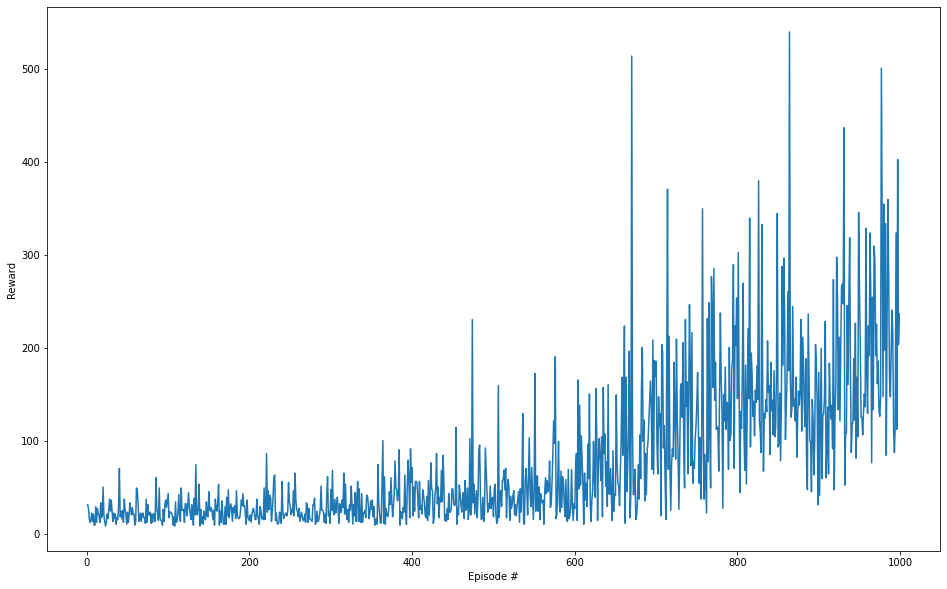

In [9]:
# Init policy, optimizer and 
policy = Policy().to(DEVICE)
optimizer = optim.AdamW(policy.parameters(), lr=0.002)
scores = REINFORCE(policy, optimizer, n_episodes=2000)
plot_reward(scores)

In [10]:
generate_video(policy, 'CartPole-v1')
embed_video('CartPole-v1')

Moviepy - Building video video/CartPole-v1.mp4.
Moviepy - Writing video video/CartPole-v1.mp4



Moviepy - Done !
Moviepy - video ready video/CartPole-v1.mp4


---